# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.6' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

2025-01-24 17:42:43.025557: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Config and fiduc

In [2]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 4030
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)

SLURM_ARRAY_TASK_ID: 4030


In [3]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p") or True:
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([640., 640., 640.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Saving model and truth at /feynman/home/dphp/hs276503/scratch/pickles/m128_b640.0_al0.5_ao0.5_lo0_pc3_obmesh/


## Run

### NUTS, HMC

In [4]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
from jax import value_and_grad

def optimize(potential, start, lr0=0.1, n_epochs=100):
    energies = []

    lr_fn = lambda i: lr0 / (1 + i)**.5
    opt_init, opt_update, get_params = adam(lr_fn)
    opt_state = opt_init(start)

    @jit
    def step(step, opt_state):
        value, grads = value_and_grad(potential)(get_params(opt_state))
        opt_state = opt_update(step, grads, opt_state)
        return value, opt_state

    for i_epoch in tqdm(range(n_epochs)):
        value, opt_state = step(i_epoch, opt_state)
        energies.append(value.astype(float))
    params = get_params(opt_state)
    return params, energies

# Warmupping...


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)



run 0/0 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'obs', 'sigma8_'])


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


MSEs: [2.8344631 2.7694123 2.8126671 2.8881092 2.80928   2.8740516 2.8656354
 2.865788 ] [2.8344631 2.7694123 2.8126671 2.8881092 2.80928   2.8740516 2.8656354
 2.865788 ]
mean_acc_prob: [0.6396681  0.63678306 0.6297745  0.6485319  0.6339803  0.6367894
 0.6426245  0.6333997 ] 
ss: [0.06198888 0.06481736 0.02417954 0.14722879 0.05098005 0.04245967
 0.07661586 0.02942245] 
mm_sqrt: {('init_mesh_',): Array([[1.3689008 , 0.9805689 , 0.90478754, ..., 1.1987973 , 1.270564  ,
        1.3771422 ],
       [0.8471658 , 1.2878509 , 0.88189   , ..., 1.3962431 , 1.1078856 ,
        1.2310404 ],
       [1.5896798 , 1.126435  , 0.887571  , ..., 0.839564  , 1.2153832 ,
        1.1899377 ],
       ...,
       [0.90931904, 1.0317589 , 1.1813232 , ..., 1.3476113 , 1.4771494 ,
        1.3254435 ],
       [1.3025032 , 1.119259  , 1.7684458 , ..., 1.4098102 , 0.81902575,
        1.0347027 ],
       [1.1137096 , 0.91095114, 0.8418976 , ..., 0.98238003, 1.4450665 ,
        1.2044885 ]], dtype=float32)}
dict_k

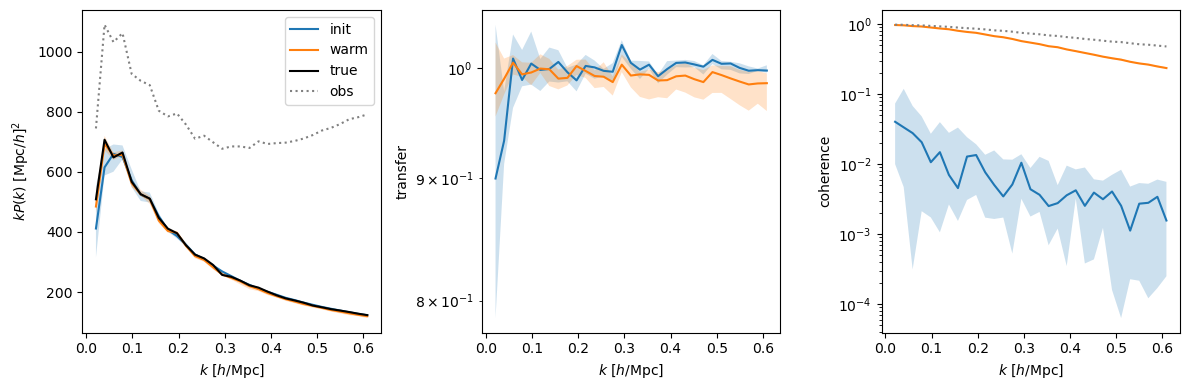

In [6]:
continue_run = False
optim = False
if continue_run:
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)

    last_state = pload(save_path + "_last_state.p")
    mcmc.num_warmup = 0
    mcmc.post_warmup_state = last_state
    init_params_ = None
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    model.block()

    mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    print("# Warmupping...")
    # init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(45), mcmc.num_chains))
    init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)

    init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
    if optim==False:
        mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        ils = mcmc.last_state.z
    else:
        warmup_params, energies = vmap(partial(optimize, model.potential, lr0=1., n_epochs=100))(init_mesh_)
        print(warmup_params.keys(), jnp.shape(energies))
        ils = warmup_params

        plt.figure(figsize=(6,4))
        plt.plot(energies)
        plt.xlabel("Epoch"), plt.ylabel("Potential")
        # plt.savefig(save_dir+f'optimpk_{task_id}.png')
        plt.savefig(f'optimpk_{task_id}.png')
        plt.show()

    ################
    from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    kpk0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    kpkobs = model.spectrum(truth['obs']-1)
    
    print(ils.keys(), init_params_.keys())

    mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    print("MSEs:", mse_, mse_)

    prob = 0.95
    plt.figure(figsize=(12, 4))
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    plot_powtranscoh(*kptcs__, fill=prob)
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    plot_powtranscoh(*kptcs_, fill=prob)
    plt.subplot(131)
    plot_pow(*kpk0, 'k', label='true')
    plot_pow(*kpkobs, ':', c='grey', label='obs')
    plt.legend()
    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.tight_layout()
    # plt.savefig(save_dir+f'initpk_{task_id}.png')
    plt.savefig(f'init_prior_128_pm_{task_id}.png')

    if optim==False:
        print("mean_acc_prob:", mcmc.last_state.mean_accept_prob, 
            "\nss:", mcmc.last_state.adapt_state.step_size, 
            "\nmm_sqrt:", mcmc.last_state.adapt_state.mass_matrix_sqrt)
    ################
    
    init_params_ |= ils
    # init_params_ |= mcmc.last_state.z
    print(init_params_.keys())
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()

In [6]:
if optim==False:
    print("mean_acc_prob:", mcmc.last_state.mean_accept_prob, 
        "\nss:", mcmc.last_state.adapt_state.step_size, 
        "\nmm_sqrt:", mcmc.last_state.adapt_state.mass_matrix_sqrt)

mean_acc_prob: [0.60841894 0.6157956  0.6099364 ] 
ss: [0.00163807 0.00276356 0.00148503] 
mm_sqrt: {('init_mesh_',): Array([[ 2.7859101, 25.849583 , 15.619893 , ...,  6.08724  ,  3.9946313,
         2.5706582],
       [ 7.597083 , 22.216284 , 11.508197 , ...,  5.17095  ,  7.401971 ,
        11.755279 ],
       [ 4.2236934, 18.670557 ,  8.761537 , ...,  3.0300026,  2.508557 ,
         5.7408524]], dtype=float32)}


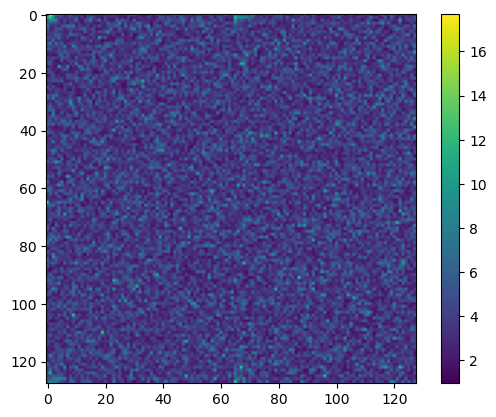

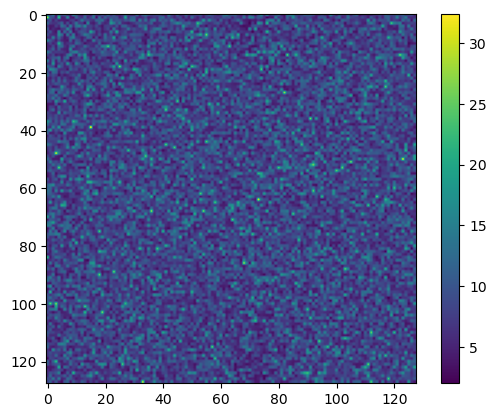

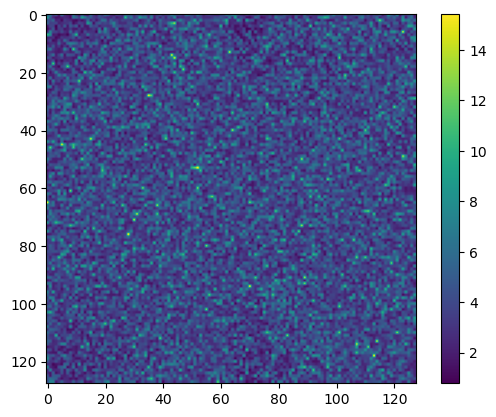

In [25]:
plt.figure()
plt.imshow(mcmc.last_state.adapt_state.mass_matrix_sqrt[('init_mesh_',)].reshape(3,128,128,128)[0,...,0])
plt.colorbar()
plt.figure()
plt.imshow(mcmc.last_state.adapt_state.mass_matrix_sqrt[('init_mesh_',)].reshape(3,128,128,128)[1,...,0])
plt.colorbar()
plt.figure()
plt.imshow(mcmc.last_state.adapt_state.mass_matrix_sqrt[('init_mesh_',)].reshape(3,128,128,128)[2,...,0])
plt.colorbar()

In [ ]:
if mcmc_config['sampler'] != 'NUTSwG':
    mcmc = get_mcmc(model.model, mcmc_config)
    mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)

else:
    from montecosmo.samplers import NUTSwG_init, get_NUTSwG_warm, get_NUTSwG_run

    step_fn, init_fn, parameters, init_state_fn = NUTSwG_init(model.logpdf)
    warmup_fn = jit(vmap(get_NUTSwG_warm(model.logpdf, parameters, mcmc_config['n_samples'])))
    last_state = jit(vmap(init_state_fn))(init_params_)
    # last_state = pload(save_dir+"NUTSGibbs/HMCGibbs_ns256_x_nc8_laststate32.p")


    (last_state, parameters), samples, infos = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), last_state)
    print("parameters:", parameters,
            "infos:", infos, '\n#################\n')
    jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(last_state, save_path+f"_last_state.p")
    # pdump(parameters, save_path+'_parameters.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    run_fn = jit(vmap(get_NUTSwG_run(model.logpdf, step_fn, init_fn, mcmc_config['n_samples'])))
    start = 1
    end = start + mcmc_config['n_runs']-1
    key = jr.key(42)
    for i_run in range(start, end+1):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        last_state, samples, infos = run_fn(jr.split(run_key, mcmc_config['n_chains']), last_state, parameters=parameters)
        print("infos:", infos)
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(last_state, save_path+f"_last_state.p")

In [ ]:
# model.reset()
# model.condition({'obs': truth['obs']})
# model.block()
# mcmc = get_mcmc(model.model, mcmc_config)
# init_params_ = {k+'_': jnp.broadcast_to(truth[k+'_'], (mcmc_config['n_chains'], *jnp.shape(truth[k+'_']))) for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

# mcmc_runned = sample_and_save(mcmc, mcmc_config['n_runs'], save_path, extra_fields=['num_steps'], init_params=init_params_)